# Image Captioning Using Deep Learning and NLP Techniques

In [87]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.compat.v1.keras.backend import set_session
import keras 
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
#Configuring the GPU memory to be used for training purposes
import tensorflow as tf

# Configure GPU memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95  # Allocate 95% of GPU memory per process
config.gpu_options.visible_device_list = "0"  # Limit TensorFlow to use only the GPU with index 0
set_session(tf.compat.v1.Session(config=config))

def set_seed(sd=8):
    # Set random seed for reproducibility
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    
    seed(sd)  # Set seed for NumPy random module
    rn.seed(sd)  # Set seed for Python random module
    set_random_seed(sd)  # Set seed for TensorFlow random module


In [15]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "Images"
## The location of the caption file
dir_Flickr_text = "Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8092


In [17]:
import pandas as pd
from collections import Counter

file = open(dir_Flickr_text, 'r', encoding='utf8')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) < 2:  
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt, columns=["filename", "index", "caption"])

uni_filenames = df_txt["filename"].unique()
print("The number of unique file names: {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
print(Counter(df_txt["filename"].value_counts().values))
print(df_txt.head())


The number of unique file names: 8092
The distribution of the number of captions for each image:
Counter({5: 8092})
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


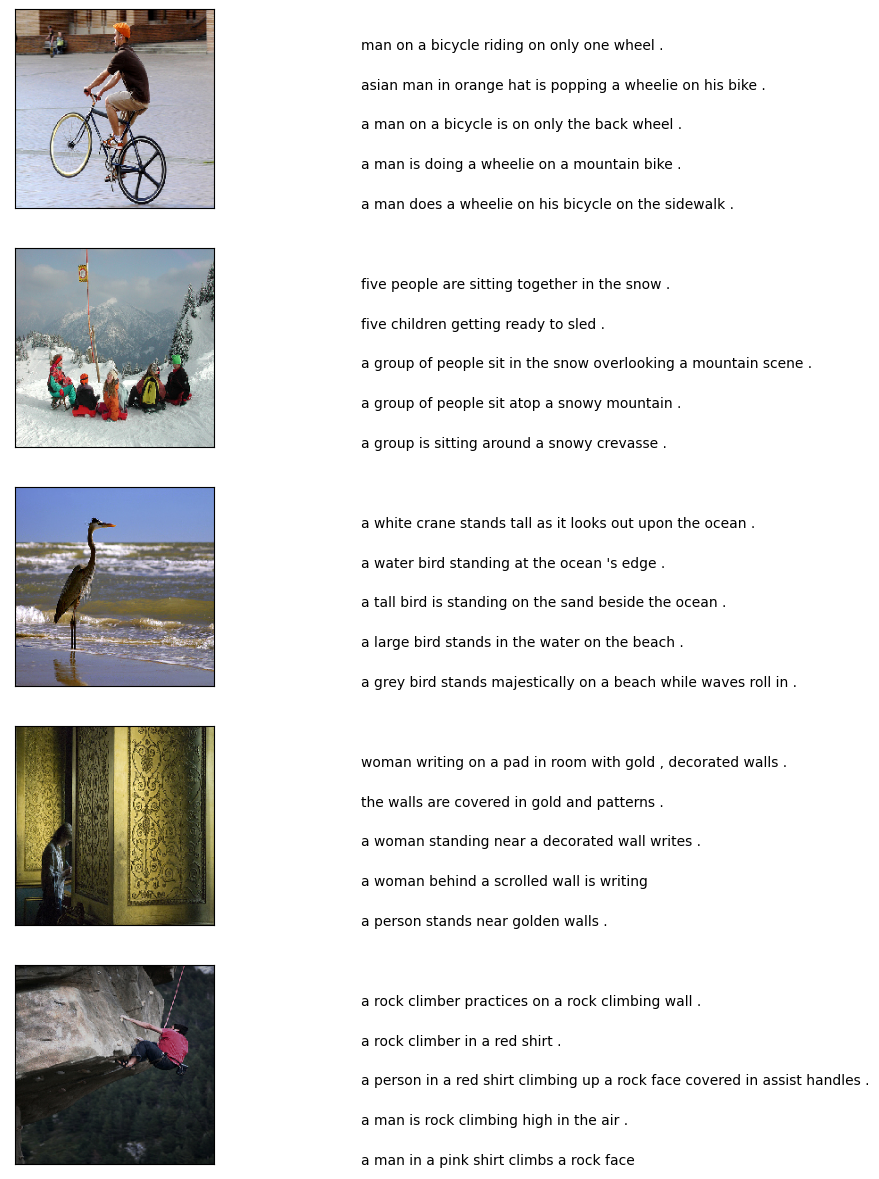

In [32]:
#Plotting few Images and their captions from the dataset
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from IPython.display import display

npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1 
fig = plt.figure(figsize=(10, 15))  # Reduced figure size

for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"] == jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=10)  # Reduced fontsize
    count += 1

plt.show()


In [34]:
#Cleaning captions for further Analysis¶
from collections import Counter
import pandas as pd

def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    
    ct = Counter(vocabulary)
    
    dfword = pd.DataFrame({'word': list(ct.keys()), "count": list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False).reset_index()[["word", "count"]]
    
    return dfword

dfword = df_word(df_txt)
dfword.head()


Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975
3  the  18419
4   on  10744

In [37]:
#Cleaning the captions
import string

text_original = "I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me"

print("Original sentence:", text_original)
print("\nRemoving Punctuations...")

def remove_punctuation(text_original):
    text_without_punct = text_original.translate(str.maketrans('', '', string.punctuation))
    return text_without_punct

text_without_punct = remove_punctuation(text_original)
print(text_without_punct)
print("\nRemoving single characters...")
def removing_single_char(text):
    text_len_greater_than_one = " ".join(word for word in text.split() if len(word) > 1)
    return text_len_greater_than_one

text_len_greater_than_one = removing_single_char(text_without_punct)
print(text_len_greater_than_one)

print("\nRemoving numeric values...")
def remove_numeric(text, printTF=False):
    text_without_num = " ".join(word for word in text.split() if word.isalpha())
    if printTF:
        for word in text.split():
            print("     {:10} : {:}".format(word, word.isalpha()))
    return text_without_num

text_without_num = remove_numeric(text_len_greater_than_one, printTF=True)


Original sentence: I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me

Removing Punctuations...
I ate 8 burgers and 4 pizzas its 944 am can you play chess with me

Removing single characters...
ate burgers and pizzas its 944 am can you play chess with me

Removing numeric values...
     ate        : True
     burgers    : True
     and        : True
     pizzas     : True
     its        : True
     944        : False
     am         : True
     can        : True
     you        : True
     play       : True
     chess      : True
     with       : True
     me         : True


In [38]:
#applying functions to our data(Image captions)
import string

# Function to clean text by removing punctuation, single characters, and numeric values
def text_clean(text_original):
    # Remove punctuation
    text = remove_punctuation(text_original)
    
    # Remove single characters
    text = removing_single_char(text)
    
    # Remove numeric values
    text = remove_numeric(text)
    
    return text

# Loop through captions in the DataFrame and apply text cleaning
for i, caption in enumerate(df_txt.caption.values):
    new_caption = text_clean(caption)
    df_txt['caption'].iloc[i] = new_caption


Vocabulary Size: 8763


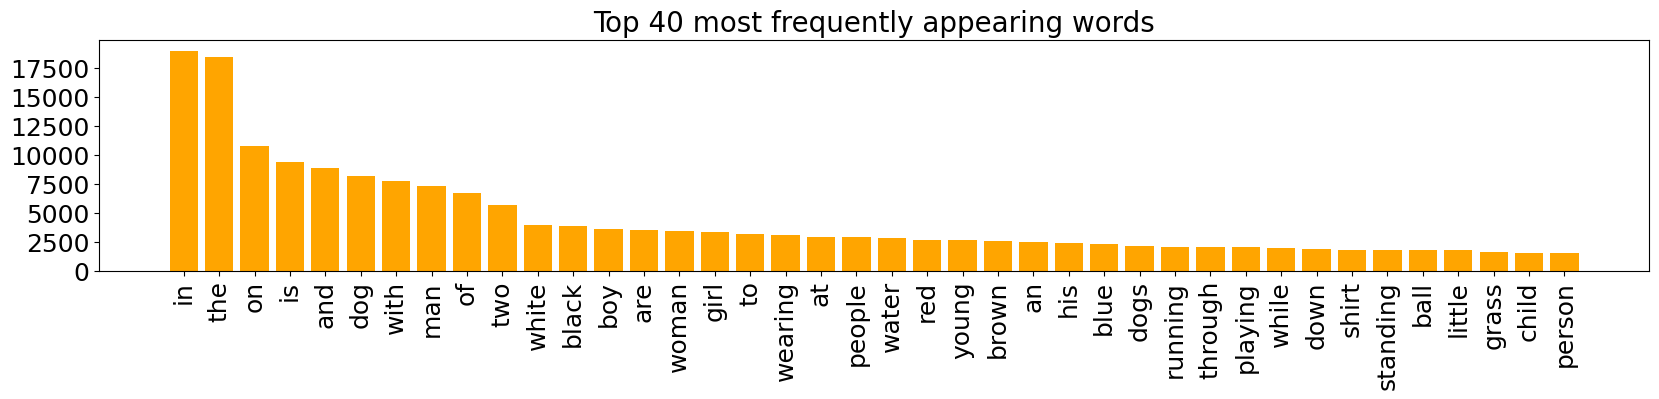

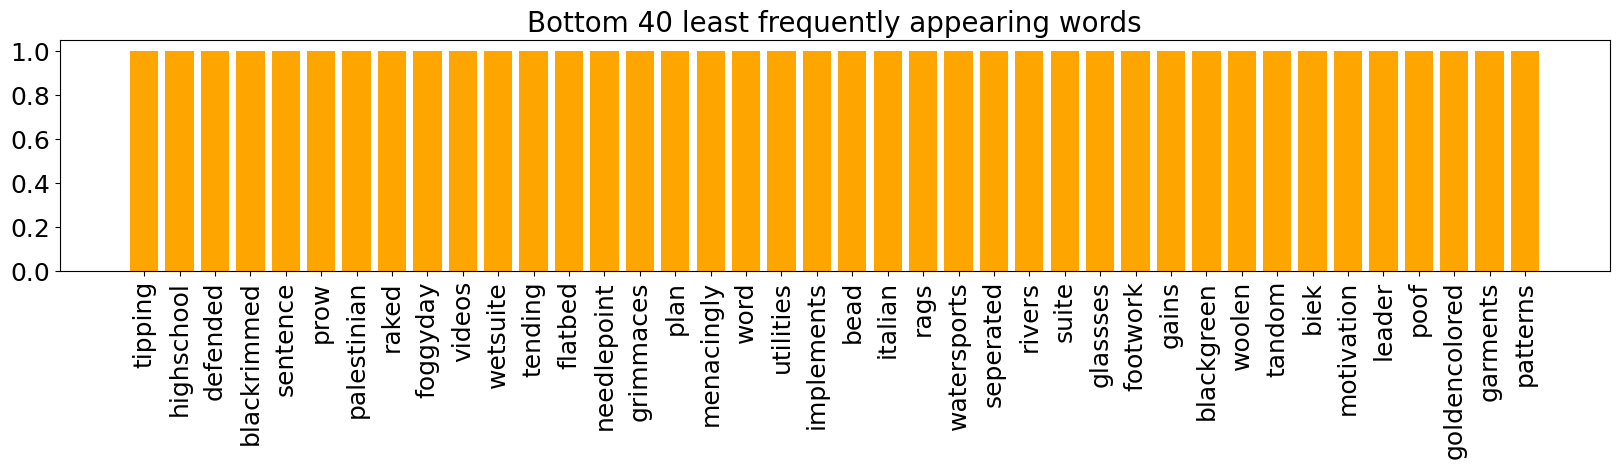

In [46]:
# Plotting the top 40 and bottom 40 words that occur in the Cleaned Dataset
top_n = 40

def plot_histogram(df_sub, title="Plotting top 40 words that occur in the Cleaned Dataset"):
    colors = ['orange' for _ in range(len(df_sub))]  # Change 'skyblue' to the desired color
    plt.figure(figsize=(20, 3))
    plt.bar(df_sub.index, df_sub["count"], color=colors)
    plt.yticks(fontsize=18)
    plt.xticks(df_sub.index, df_sub["word"], rotation=90, fontsize=18)
    plt.title(title, fontsize=20)
    plt.show()

# Calculate word frequencies and plot the top and bottom 40 words
df_word_cleaned = df_word(df_txt)
plot_histogram(df_word_cleaned.iloc[:top_n, :], title="Top 40 most frequently appearing words")
plot_histogram(df_word_cleaned.iloc[-top_n:, :], title="Bottom 40 least frequently appearing words")



In [47]:
#Start and End Sequence has to be added to the tokens so that it's easier to identify 
#the captions for the image as each of them are of different length

from copy import copy
def add_tokens(captions):
    caps = []
    for txt in captions:
        txt = "startseq" + txt + " endseq"
        caps.append(txt)
    return caps
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_tokens(df_txt["caption"])
df_txt0.head(5)

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseqchild in pink dress is climbing up set...  
1     startseqgirl going into wooden building endseq  
2  startseqlittle girl climbing into wooden playh...  
3  startseqlittle girl climbing the stairs to her...  
4  startseqlittle girl in pink dress going into w...

In [48]:
from keras.applications import VGG16

# Load VGG16 model with pre-trained weights
model_vgg = VGG16(include_top=True, weights='imagenet')  # Use 'imagenet' to load pre-trained weights

# Display model summary
model_vgg.summary()


553467096/553467096 [==============================] - 543s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [50]:
# Deleting the last layer of the Model
from keras.models import Sequential
from keras import models

model = Sequential()
for layer in model_vgg.layers[:-1]:
    model.add(layer)

final_vgg_model = models.Model(inputs=model.inputs, outputs=model.layers[-1].output)

# Display the summary of the modified model
final_vgg_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import os

images = OrderedDict()
npix = 224  # image size fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix, npix, 3)
data = np.zeros((len(jpgs), npix, npix, 3))

for i, name in enumerate(jpgs):
    filename = os.path.join(dir_Flickr_jpg, name)
    
    # Skip directories
    if os.path.isdir(filename):
        continue
    
    try:
        image = load_img(filename, target_size=target_size)
        image = img_to_array(image)
        nimage = preprocess_input(image)

        y_pred = final_vgg_model.predict(nimage.reshape((1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
    except Exception as e:
        print(f"Error processing {filename}: {e}")



1/1 [==============================] - 0s 450ms/step


In [54]:
#plotting similar images from the dataset¶
from sklearn.decomposition import PCA
encoder = np.array(list(images.values()))
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

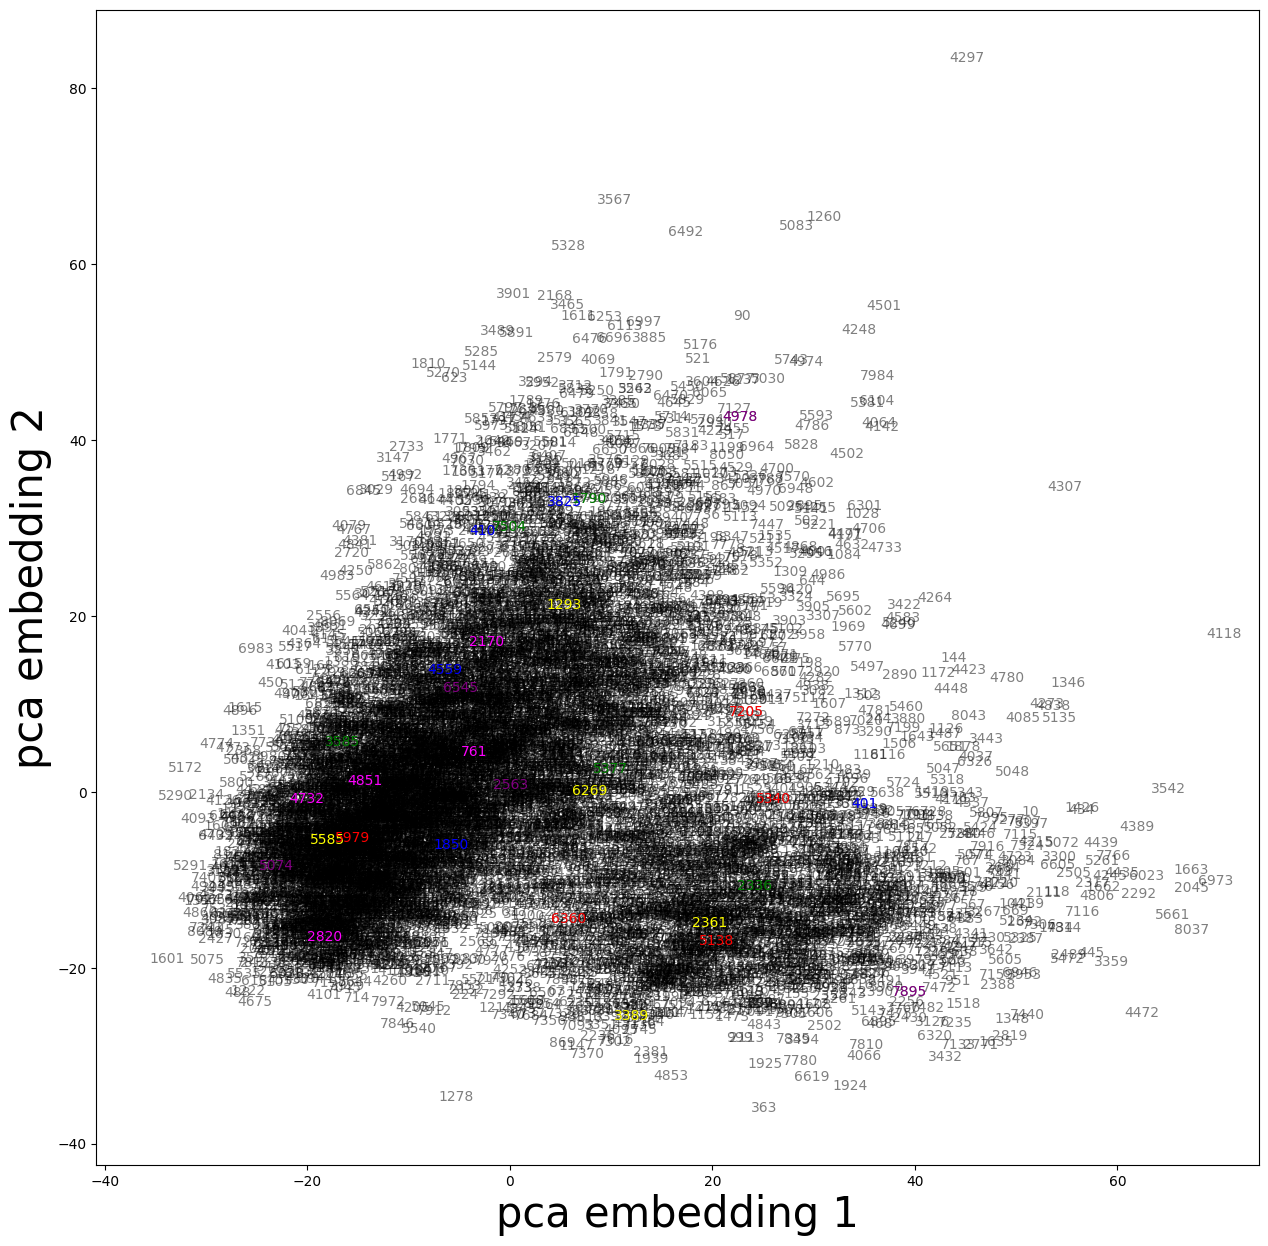

In [86]:
## some selected pictures that are cretaing clusters
# these are just to display the related images from the dataset

picked_picture = OrderedDict()
picked_picture["yellow"] = [1293, 3389, 6269, 5585, 2361]
picked_picture["green"] = [2336, 3585, 1790, 5377, 7504]
picked_picture["magenta"] = [2170, 4732, 761, 4851, 2820]
picked_picture["blue"] = [4559, 1850, 410, 401, 3825]
picked_picture["purple"] = [5074, 2563, 6545, 4978, 7895]
picked_picture["red"] = [6360, 5979, 7205, 5340, 5138]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0], y_pca[:,1], c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow, y_pca[irow,:], color="black", alpha=0.5)
for color, irows in picked_picture.items():
    for irow in irows:
        ax.annotate(irow, y_pca[irow, :], color=color)
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()
    


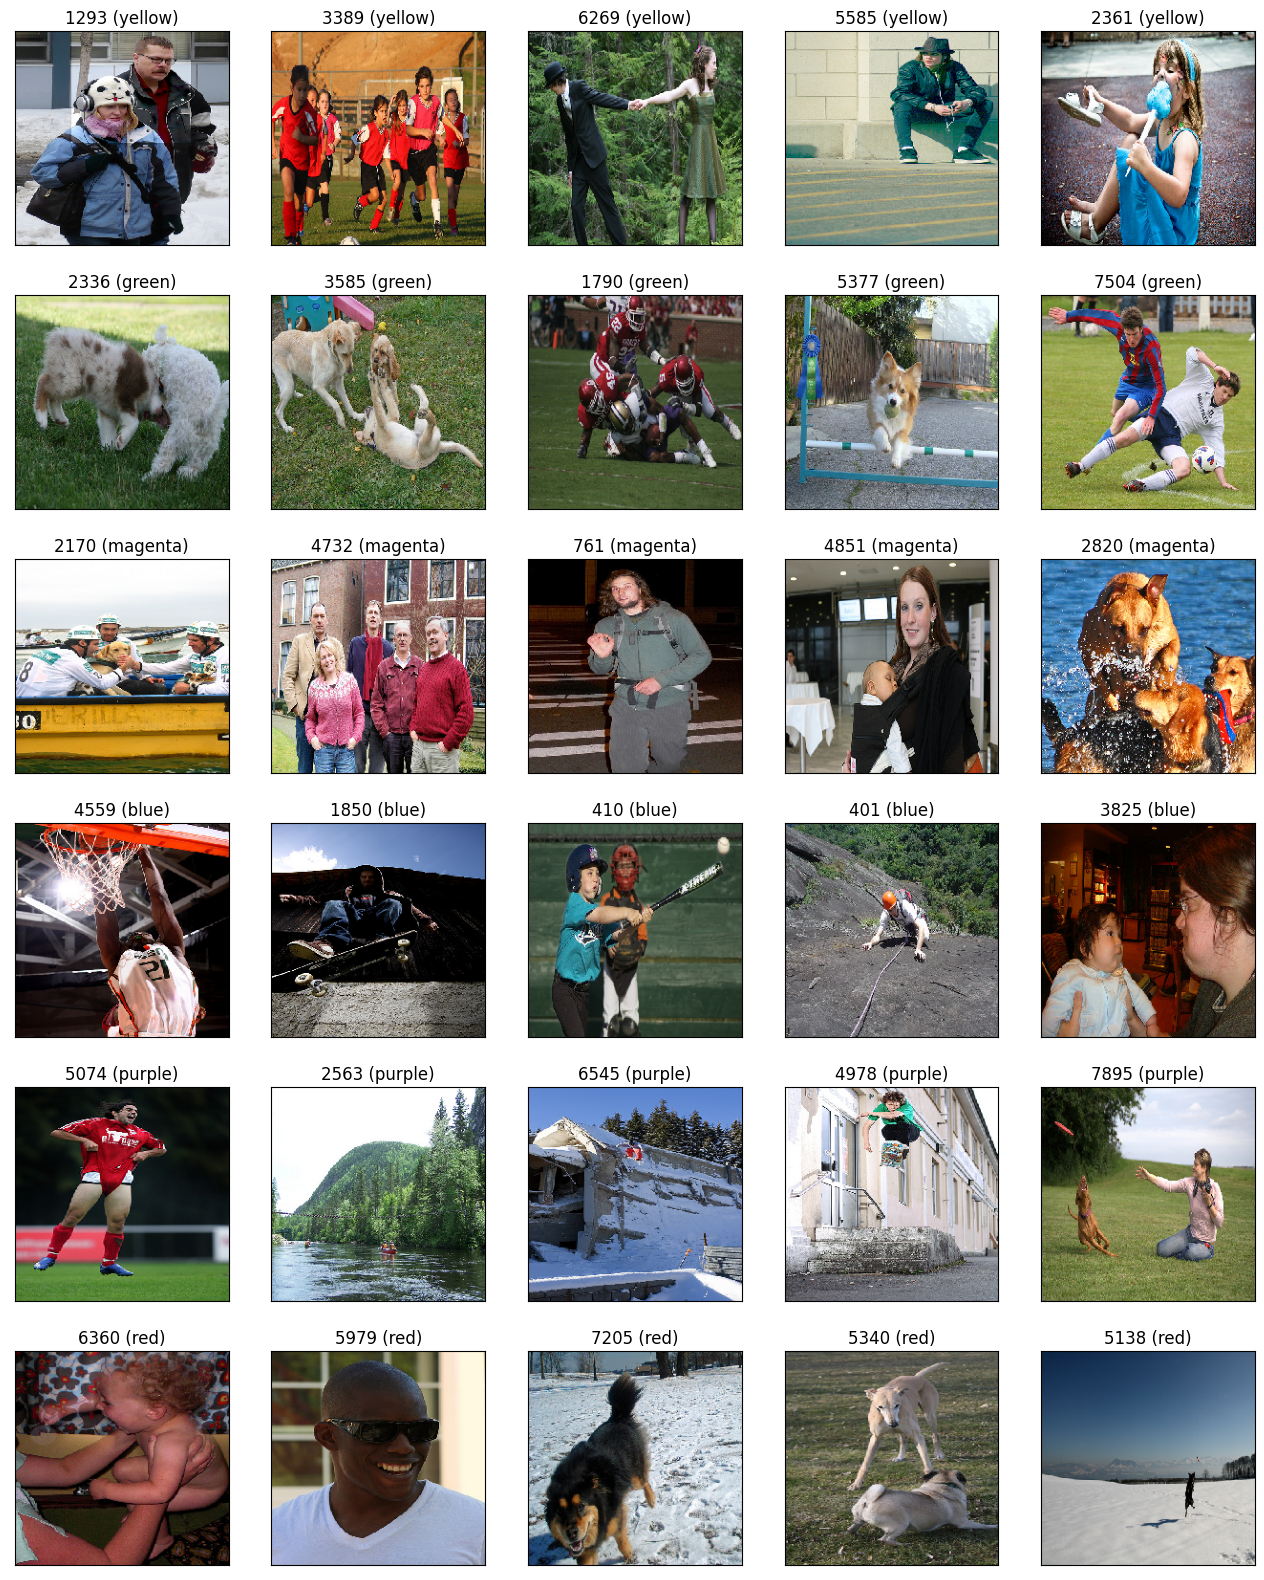

In [85]:
## plot the images
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_picture.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(len(picked_picture), 5, count, xticks=[], yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec, color))
plt.show()

In [57]:
dimages, keepindex = [], []
# creating a dataframe where only first caption is taken for model training
df_txt0 = df_txt0.loc[df_txt0["index"].values == '0',:]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
# fname are the names of the image
fnames = df_txt0["filename"].iloc[keepindex].values
# dcaptions contains captions of the images
dcaptions = df_txt0["caption"] .iloc[keepindex].values
# dimages are the actual features of the images
dimages = np.array(dimages)
df_txt0.head()

filename index  \
0   1000268201_693b08cb0e.jpg     0   
5   1001773457_577c3a7d70.jpg     0   
10  1002674143_1b742ab4b8.jpg     0   
15  1003163366_44323f5815.jpg     0   
20  1007129816_e794419615.jpg     0   

                                              caption  
0   startseqchild in pink dress is climbing up set...  
5   startseqblack dog and spotted dog are fighting...  
10  startseqlittle girl covered in paint sits in f...  
15  startseqman lays on bench while his dog sits b...  
20  startseqman in an orange hat starring at somet...

In [58]:
#Tokenizing the captions for further processing
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocubulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:3])

Vocubulary size : 4812
[[52, 2, 68, 145, 6, 123, 57, 430, 7, 391, 2, 29, 2491, 546, 1], [16, 8, 4, 837, 8, 13, 392, 1], [75, 37, 172, 2, 605, 104, 2, 44, 7, 572, 1261, 9, 60, 222, 2, 1127, 1]]


In [59]:
#Splitting the training and testing Data
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [60]:
#Finding the Max Lenghth of caption¶
maxlen = np.max([len(text) for text in dtexts])
minlen = np.min([len(text) for text in dtexts])
print("Min length of caption: {} and Max length of caption: {}".format(minlen, maxlen))

Min length of caption: 2 and Max length of caption: 29


In [61]:
#Processing the captions and images as per the model standard input type
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) 
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size) 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (44777, 29) (44777, 4096) (44777, 4812)
# captions/images = 1618
 (14736, 29) (14736, 4096) (14736, 4812)


In [63]:
#Buiding the LSTM model¶

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import LeakyReLU, PReLU


print(vocab_size)

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)

se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)
# combining model for decoder

decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

4812
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 29, 64)               307968    ['input_3[0][0]']             
                                                                                                  
 CaptionFeature (LSTM)       (None, 29, 256)              328704    ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 29, 256)              0         ['CaptionFeature[0][0]']      
                                                                                       

In [74]:
from time import time
from keras.callbacks import TensorBoard

# Increase batch size
batch_size = 64

tensorboard = TensorBoard(log_dir="log/{}".format(time()))

# Compile the model with a valid loss function (e.g., categorical cross-entropy for classification)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with the adjusted parameters
hist = model.fit(
    [Ximage_train, Xtext_train],
    ytext_train,
    epochs=6,
    verbose=2,
    batch_size=batch_size,
    validation_data=([Ximage_val, Xtext_val], ytext_val),
    callbacks=[tensorboard]
)


Epoch 1/6
700/700 - 1581s - loss: 4.5692 - accuracy: 0.2315 - val_loss: 4.7317 - val_accuracy: 0.2435 - 1581s/epoch - 2s/step
Epoch 2/6
700/700 - 1496s - loss: 4.1550 - accuracy: 0.2559 - val_loss: 4.6742 - val_accuracy: 0.2613 - 1496s/epoch - 2s/step
Epoch 3/6
700/700 - 1450s - loss: 3.8760 - accuracy: 0.2759 - val_loss: 4.6638 - val_accuracy: 0.2735 - 1450s/epoch - 2s/step
Epoch 4/6
700/700 - 1416s - loss: 3.6528 - accuracy: 0.2916 - val_loss: 4.7499 - val_accuracy: 0.2757 - 1416s/epoch - 2s/step
Epoch 5/6
700/700 - 1495s - loss: 3.4669 - accuracy: 0.3034 - val_loss: 4.8015 - val_accuracy: 0.2813 - 1495s/epoch - 2s/step
Epoch 6/6
700/700 - 1458s - loss: 3.2983 - accuracy: 0.3148 - val_loss: 4.9243 - val_accuracy: 0.2808 - 1458s/epoch - 2s/step


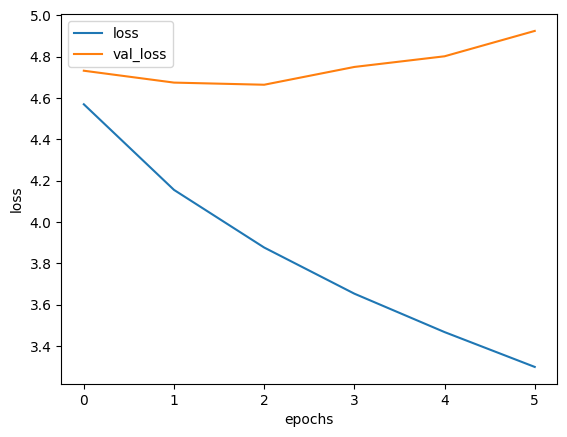

In [75]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

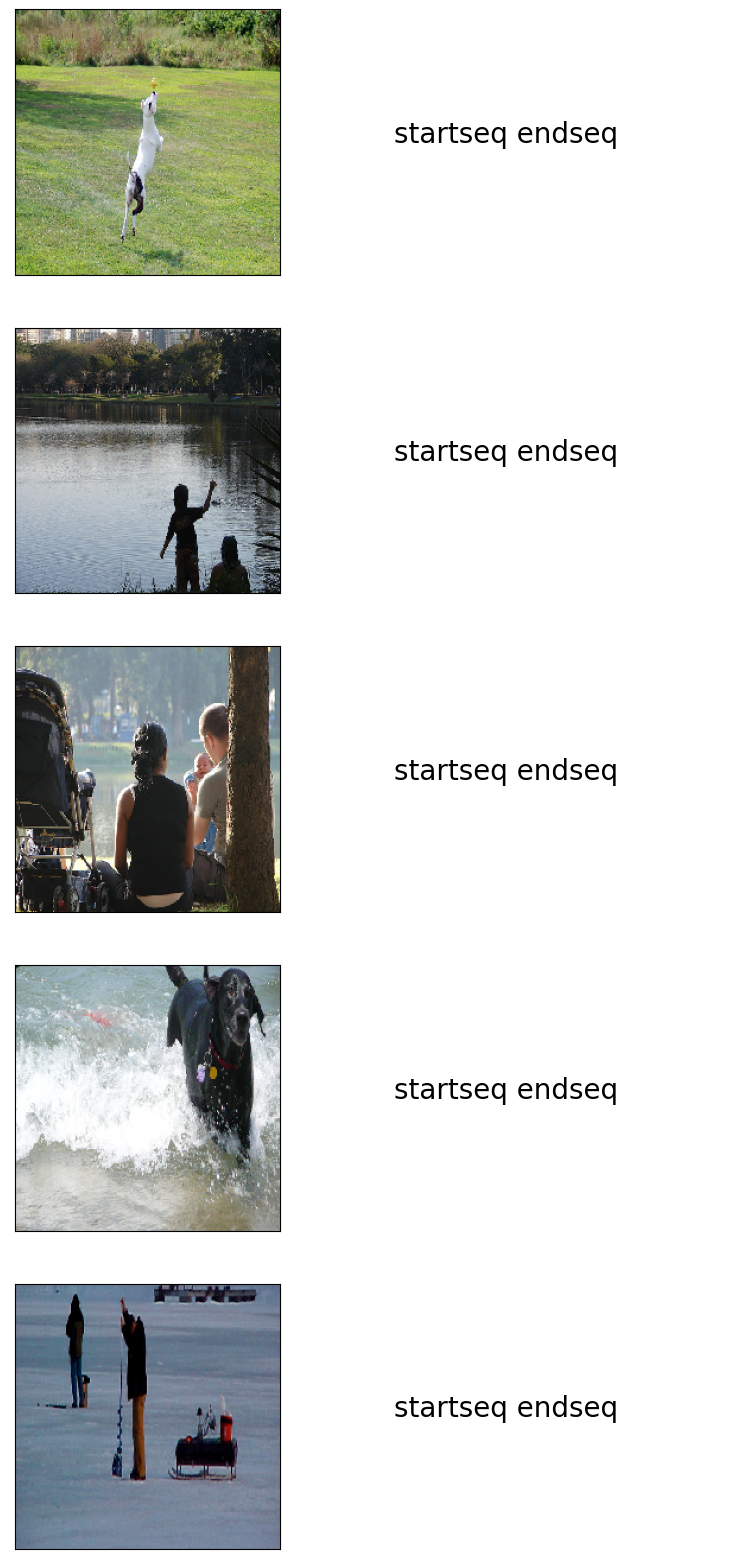

In [76]:
#Generating captions on a small set of images¶
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    
    in_text = 'startseq'
    
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " "+ newword
        if newword == "endseq":
            break
    return in_text

npic = 5
npix = 224
target_size = (npix, npix, 3)
count = 1

fig = plt.figure(figsize=(10,20))

for jpgfnm, image_feature in zip(fnm_test[15:20], di_test[15:20]):
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1
    
plt.show()

In [79]:
from nltk.translate.bleu_score import sentence_bleu

reference_sentence = "The quick brown fox jumps over the lazy dog."

hypothesis2 = "I love dog!".split()

bleu_score = sentence_bleu([reference_sentence.split()], hypothesis2)
print("BLEU={:4.3f}".format(bleu_score))


BLEU=0.000


In [80]:
#Generating captions for the whole testset and finding BLEU score¶

index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

nkeep = 5 
pred_strong, pred_weak, bleus = [], [], []
count = 0

for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("   {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
        
    caption_true = [index_word[i] for i in tokenized_text]
    caption_true = caption_true[1:-1]
    
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]
    
    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)
    
    if bleu > 0.7 and len(pred_strong) < nkeep:
        pred_strong.append((bleu, jpgfnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_weak) < nkeep:
        pred_weak.append((bleu, jpgfnm, caption_true, caption))

   12.36% is done..
   24.72% is done..
   37.08% is done..
   49.44% is done..
   61.80% is done..
   74.17% is done..
   86.53% is done..
   98.89% is done..


In [81]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.000


Weak Captions


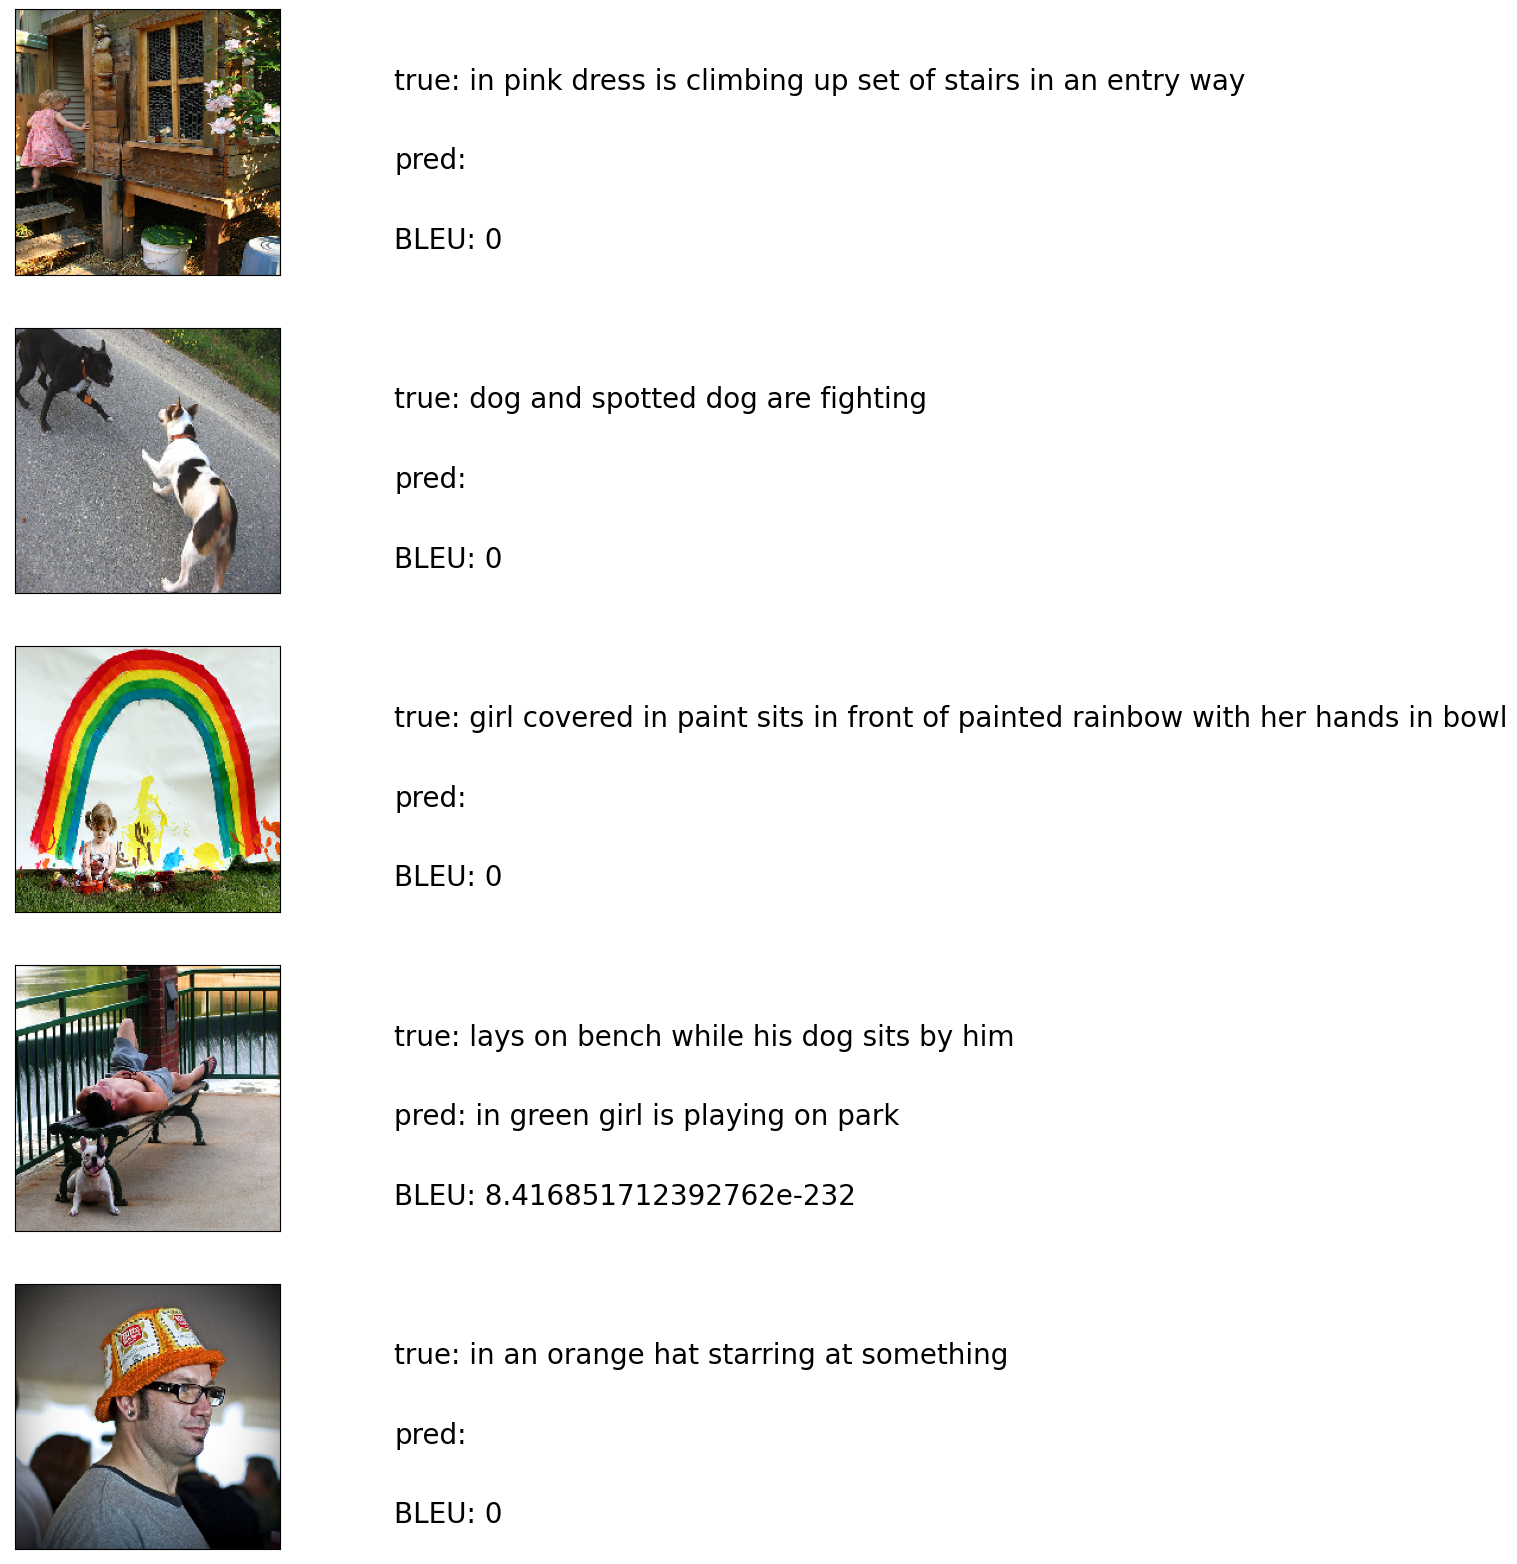

Strong Captions


<Figure size 1000x2000 with 0 Axes>

In [83]:
# Assuming you have the necessary imports
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

def plot_images(pred_weak):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return strue
    
    npix = 224
    target_size = (npix, npix, 3)
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_weak)
    
    for pw in pred_weak:
        bleu, jpgfnm, caption_true, caption = pw
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1
        
        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0, 0.7, "true:" + caption_true, fontsize=20)
        ax.text(0, 0.4, "pred:" + caption, fontsize=20)
        ax.text(0, 0.1, "BLEU: {}".format(bleu), fontsize=20)
        count += 1
    
    plt.show()

print("Weak Captions")
plot_images(pred_weak)
print("Strong Captions")
plot_images(pred_strong)
